# Exploratory Data Analysis - Crime Data Los Angeles

This notebook is used to explore the questions for the Data Scientist Exercise in July 2020.

- How else has reported crime changed over time in the City?
- Based on your analysis, please share any changes to services, programs, or policies that the City should consider.

##  Load libraries

In [11]:
# Import libraries
import os, sys, subprocess
import json
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib import dates as mdates
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', 500)
%config InlineBackend.figure_format = 'retina'
# sns.set(style="whitegrid") 
plt.style.use('fivethirtyeight')

In [2]:
# load project config
terminal_call = ! git rev-parse --show-toplevel
repo_path=terminal_call[0]
project_config_path = os.path.join(repo_path,'project_config.json')

with open(project_config_path,'r') as fp: 
    project_config = json.load(fp)

In [4]:
# import custom module to look at trends
module_path = os.path.join(repo_path,project_config['project_module_relative_path'])
sys.path.append(module_path)

import trends
from trends import get_top_trends as gt
from trends import convert
from trends.convert import crime_dict, mocode_dict, violent_crime_dict # load in crime name dictionary
from importlib import reload # for updating scripts

# Load in data

In [5]:
# load in data that was collected
df = pickle.load(open("../data/crime_data.pkl", "rb"))

In [5]:
# Explore summary info
def eda(df):
    nulls = pd.DataFrame(df.isnull().sum()).T # Check for nulls
    datatypes = pd.DataFrame(df.dtypes).T # Check datatypes
    summary = pd.concat([nulls, datatypes], keys = ["nulls", "datatypes"]) # Create pandas dataframe, because I think it's easier to read
    return summary

In [6]:
eda(df)

,,dr_no,date_rptd,date_occ,time_occ,area,area_name,rpt_dist_no,part_1-2,crm_cd,crm_cd_desc,mocodes,vict_age,vict_sex,vict_descent,premis_cd,premis_desc,weapon_used_cd,weapon_desc,status,status_desc,crm_cd_1,crm_cd_2,crm_cd_3,crm_cd_4,location,cross_street,lat,lon,year,mocodes_1,mocodes_2,mocodes_3
nulls,0,0,0,0,0,0,0,0,0,0,0,240361,0,208478,208527,55,228,1464999,1465000,3,0,11,2063105,2206364,2209991,0,1837686,0,0,0,0,240361,240361
datatypes,0,int64,datetime64[ns],datetime64[ns],int64,int64,object,int64,int64,int64,object,object,int64,object,object,float64,object,float64,object,object,object,float64,float64,float64,float64,object,object,float64,float64,int64,int64,object,object


## How else has reported crime changed over time in the City?

In [184]:
# Code to plot time series

def plot_series(df, cols=None, title='Title', xlab=None, ylab=None, steps=1):
    
    # Set figure size to be (18, 9).
    plt.figure(figsize=(22,10))
    
    # Iterate through each column name.
    for col in cols:
            
        # Generate a line plot of the column name.
        # You only have to specify Y, since our
        # index will be a datetime index.
        plt.plot(df[col])
        
    # Generate title and labels.
    plt.title(title, fontsize=26)
    plt.xlabel(xlab, fontsize=5)
    plt.ylabel(ylab, fontsize=18)
    
    
    # Enlarge tick marks.
    plt.yticks(fontsize=18)
    plt.xticks(df.index[0::steps], fontsize=18);

In [120]:
total_crimes = pd.DataFrame(df.groupby("year").size().reset_index(name ="total_cases"))

In [189]:
total_crimes.set_index("year", inplace = True)
total_crimes.head()

,total_cases
year,
2010,200536
2011,197858
2012,200110
2013,192146
2014,194966


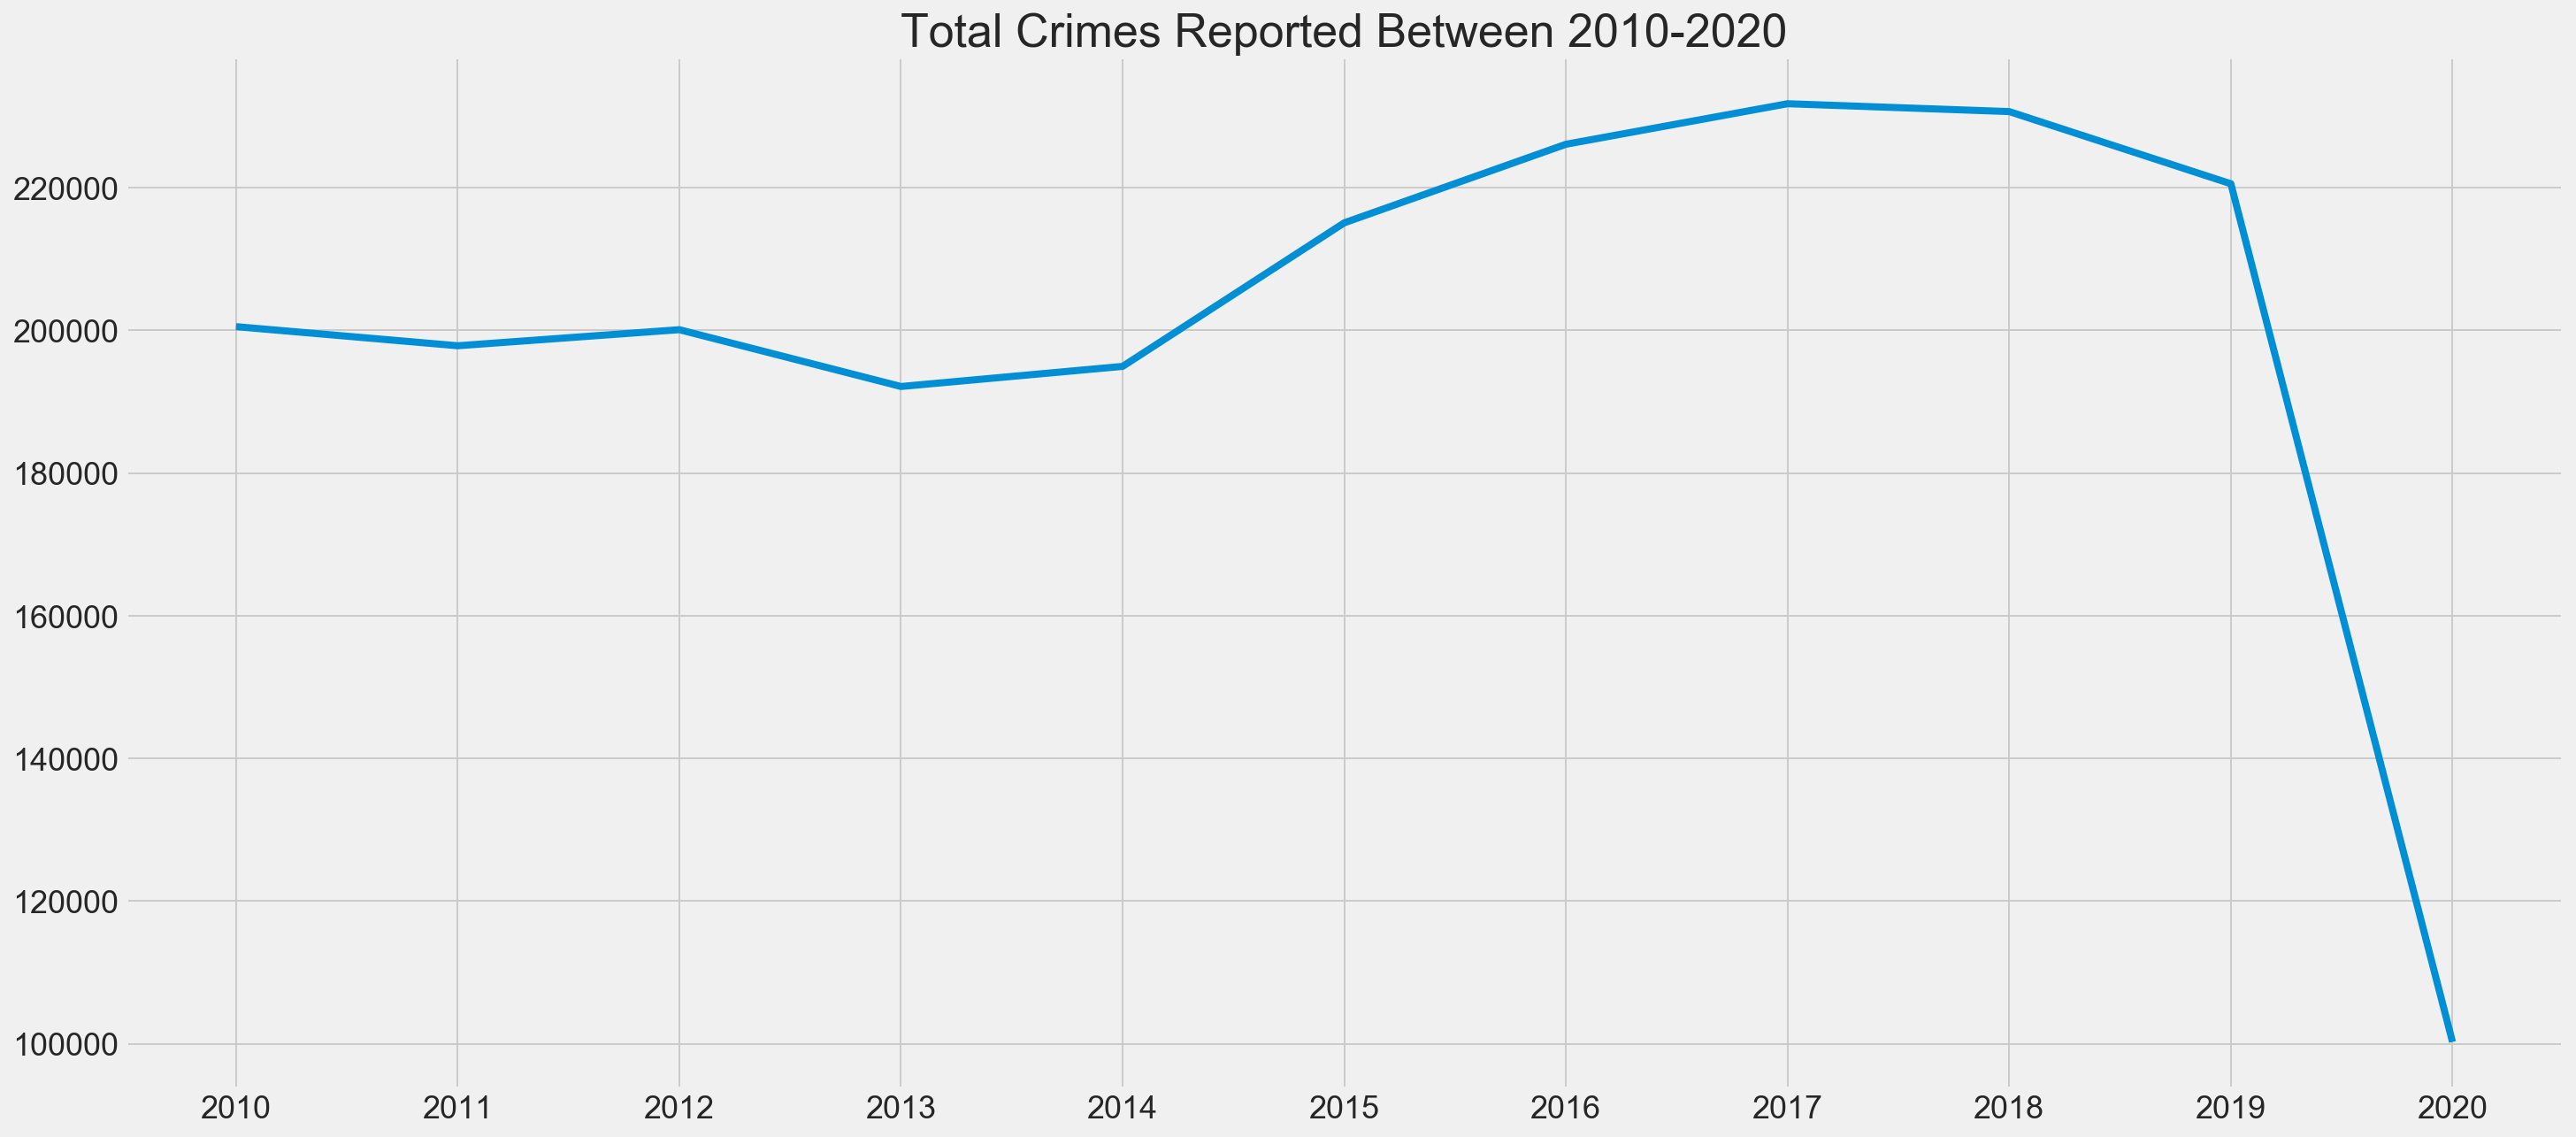

In [265]:
# Generate a time plot of our data.
plot_series(total_crimes,
            ['total_cases'],
            title = 'Total Crimes Reported Between 2010-2020',
            steps = 1);

## Calculate rolling means for daily crimes reported

In [6]:
# calculate rolling means for the number of crimes reported each day

#group by date
crimes = pd.DataFrame(df.groupby("date_rptd").size().reset_index(name ="total_cases"))
crimes.set_index("date_rptd", inplace = True)

In [7]:
# rolling mean for 1 month
crimes["rolling_mean_month"] = crimes["total_cases"].rolling(30).mean()

# quarterly rolling mean
crimes["rolling_mean_quarter"] = crimes["total_cases"].rolling(120).mean()

# annual rolling mean
crimes["rolling_mean_annual"] = crimes["total_cases"].rolling(365).mean()

In [8]:
# Code to plot time series

def plot_rolling_series(df, cols=None, title='Title', xlab=None, ylab=None, steps=1):
    
    # Set figure size 
    fig, ax = plt.subplots(figsize=(24, 10))    
    
    # Iterate through each column name.
    for col in cols: 
            
        # Generate a line plot of the column name.
        # You only have to specify Y, since our
        # index will be a datetime index.
        ax.plot(df[col])
        
    # Generate title and labels.
    plt.title(title, fontsize=26)
    plt.xlabel(xlab, fontsize=5)
    plt.ylabel(ylab, fontsize=18)
    
    
    # set x ticks to years
    years = mdates.YearLocator()   
    yearsFmt = mdates.DateFormatter('%Y')
    monthsFmt = mdates.DateFormatter('%b')
    months = mdates.MonthLocator((4,7,10))



    # set major ticks
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(yearsFmt)
    
    # set minor ticks
    ax.xaxis.set_minor_locator(months)
    ax.xaxis.set_minor_formatter(monthsFmt)

    # add minor ticks quarterly
    #ax.xaxis.set_minor_locator(AutoMinorLocator(4))
    ax.grid(which='minor', color='#cccccc', linestyle=':')
    
    # Enlarge tick marks.
    plt.yticks(fontsize=18)
    plt.xticks(fontsize=18);

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


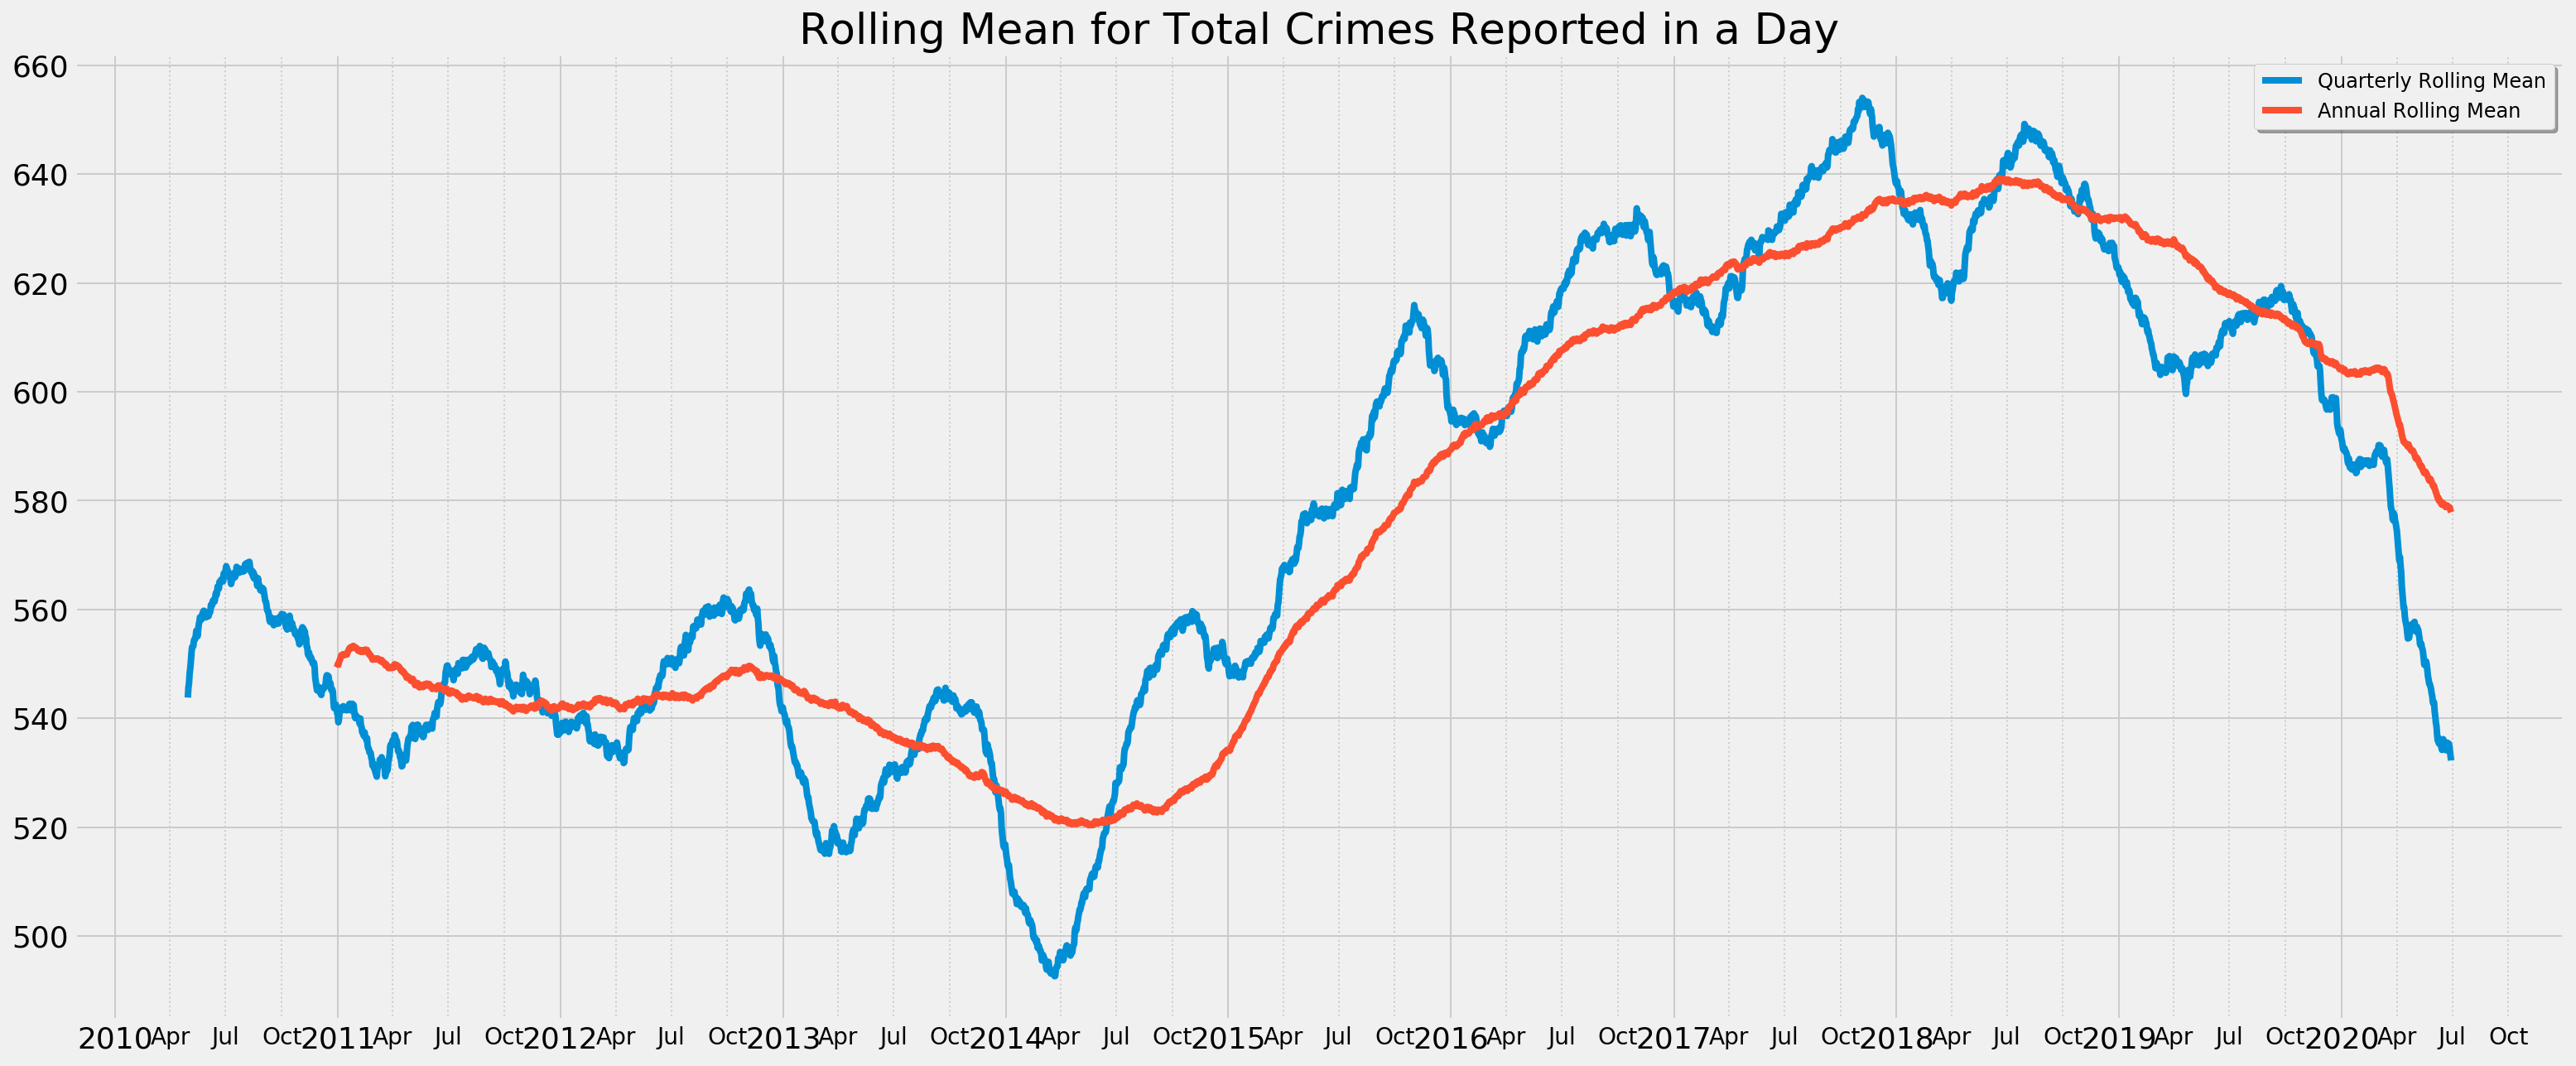

In [12]:
plot_rolling_series(crimes, ["rolling_mean_quarter", "rolling_mean_annual"], 
                    title='Rolling Mean for Total Crimes Reported in a Day')

plt.legend(labels = ["Quarterly Rolling Mean", "Annual Rolling Mean"], loc='upper right',
          fancybox=True, shadow=True, fontsize = 12);

plt.savefig('../plots/daily_reports_rolling_means.eps', format='eps', dpi=72)

## Are the crimes getting more serious over the years?

According to the datasource, lower crime class numbers are more serious [source](https://data.lacity.org/A-Safe-City/Crime-Data-from-2020-to-Present/2nrs-mtv8). 
Looking at the UCR Crime codes [here](https://data.lacity.org/api/views/63jg-8b9z/files/fff2caac-94b0-4ae5-9ca5-d235b19e3c44?download=true&filename=UCR-COMPSTAT062618.pdf), I created a dictionary of all the violent crime codes.

In [28]:
# create a column that checks if the crime is violent
df["is_violent"]= [i in violent_crime_dict.keys() for i in df["crm_cd"]]

In [34]:
# calculate the % of violent crimes each year
(df.groupby("year")["is_violent"].sum()/df.groupby("year").size()).reset_index(name="percent_violent")

,year,percent_violent
0,2010,0.310019
1,2011,0.302919
2,2012,0.291964
3,2013,0.283691
4,2014,0.300375
5,2015,0.297585
6,2016,0.297456
7,2017,0.303887
8,2018,0.306799
9,2019,0.313465


In [35]:
df.head()

,dr_no,date_rptd,date_occ,time_occ,area,area_name,rpt_dist_no,part_1-2,crm_cd,crm_cd_desc,mocodes,vict_age,vict_sex,vict_descent,premis_cd,premis_desc,weapon_used_cd,weapon_desc,status,status_desc,crm_cd_1,crm_cd_2,crm_cd_3,crm_cd_4,location,cross_street,lat,lon,year,mocodes_1,mocodes_2,mocodes_3,is_violent
0,1307355,2010-02-20,2010-02-20,1350,13,Newton,1385,2,900,VIOLATION OF COURT ORDER,0913 1814 2000,48,M,H,501.0,SINGLE FAMILY DWELLING,NaN,NaN,AA,Adult Arrest,900.0,NaN,NaN,NaN,300 E GAGE AV,NaN,33.9825,-118.2695,2010,913,"[0913, 1814, 2000]","[0913, 1814, 2000]",False
1,11401303,2010-09-13,2010-09-12,45,14,Pacific,1485,2,740,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)",0329,0,M,W,101.0,STREET,NaN,NaN,IC,Invest Cont,740.0,NaN,NaN,NaN,SEPULVEDA BL,MANCHESTER AV,33.9599,-118.3962,2010,329,[0329],[0329],False
2,70309629,2010-08-09,2010-08-09,1515,13,Newton,1324,2,946,OTHER MISCELLANEOUS CRIME,0344,0,M,H,103.0,ALLEY,NaN,NaN,IC,Invest Cont,946.0,NaN,NaN,NaN,1300 E 21ST ST,NaN,34.0224,-118.2524,2010,344,[0344],[0344],False
3,90631215,2010-01-05,2010-01-05,150,6,Hollywood,646,2,900,VIOLATION OF COURT ORDER,1100 0400 1402,47,F,W,101.0,STREET,102.0,HAND GUN,IC,Invest Cont,900.0,998.0,NaN,NaN,CAHUENGA BL,HOLLYWOOD BL,34.1016,-118.3295,2010,1100,"[1100, 0400, 1402]","[1100, 0400, 1402]",False
4,100100501,2010-01-03,2010-01-02,2100,1,Central,176,1,122,"RAPE, ATTEMPTED",0400,47,F,H,103.0,ALLEY,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont,122.0,NaN,NaN,NaN,8TH ST,SAN PEDRO ST,34.0387,-118.2488,2010,400,[0400],[0400],True


In [40]:
# calculate the % of violent crimes each year and area
violent_crimes = (df.groupby(["year", "area"])["is_violent"].sum()/df.groupby(["year", "area"]).size()).reset_index(name="percent_violent")

In [68]:
violent_crimes.head()

,year,area,percent_violent
0,2010,1,0.391248
1,2010,2,0.418766
2,2010,3,0.362579
3,2010,4,0.348423
4,2010,5,0.275000


In [153]:
# only select for year 2010 and 2020
violent_crimes = violent_crimes[(violent_crimes["year"]== 2010) | (violent_crimes["year"]== 2020)]

In [154]:
# conditional color. Color red if the % violent crime increased over the 10 years
highlight = ['#77f56b' if (violent_crimes[violent_crimes["area"] == i]["percent_violent"].values[1] > violent_crimes[violent_crimes["area"] == i]["percent_violent"].values[0]) else "#3c8fd0" for i in violent_crimes["area"]]

In [157]:
highlight

['#3c8fd0',
 '#3c8fd0',
 '#77f56b',
 '#3c8fd0',
 '#77f56b',
 '#3c8fd0',
 '#77f56b',
 '#3c8fd0',
 '#3c8fd0',
 '#77f56b',
 '#3c8fd0',
 '#77f56b',
 '#3c8fd0',
 '#77f56b',
 '#77f56b',
 '#3c8fd0',
 '#77f56b',
 '#77f56b',
 '#3c8fd0',
 '#3c8fd0',
 '#77f56b',
 '#3c8fd0',
 '#3c8fd0',
 '#77f56b',
 '#3c8fd0',
 '#77f56b',
 '#3c8fd0',
 '#77f56b',
 '#3c8fd0',
 '#3c8fd0',
 '#77f56b',
 '#3c8fd0',
 '#77f56b',
 '#3c8fd0',
 '#77f56b',
 '#77f56b',
 '#3c8fd0',
 '#77f56b',
 '#77f56b',
 '#3c8fd0',
 '#3c8fd0',
 '#77f56b']

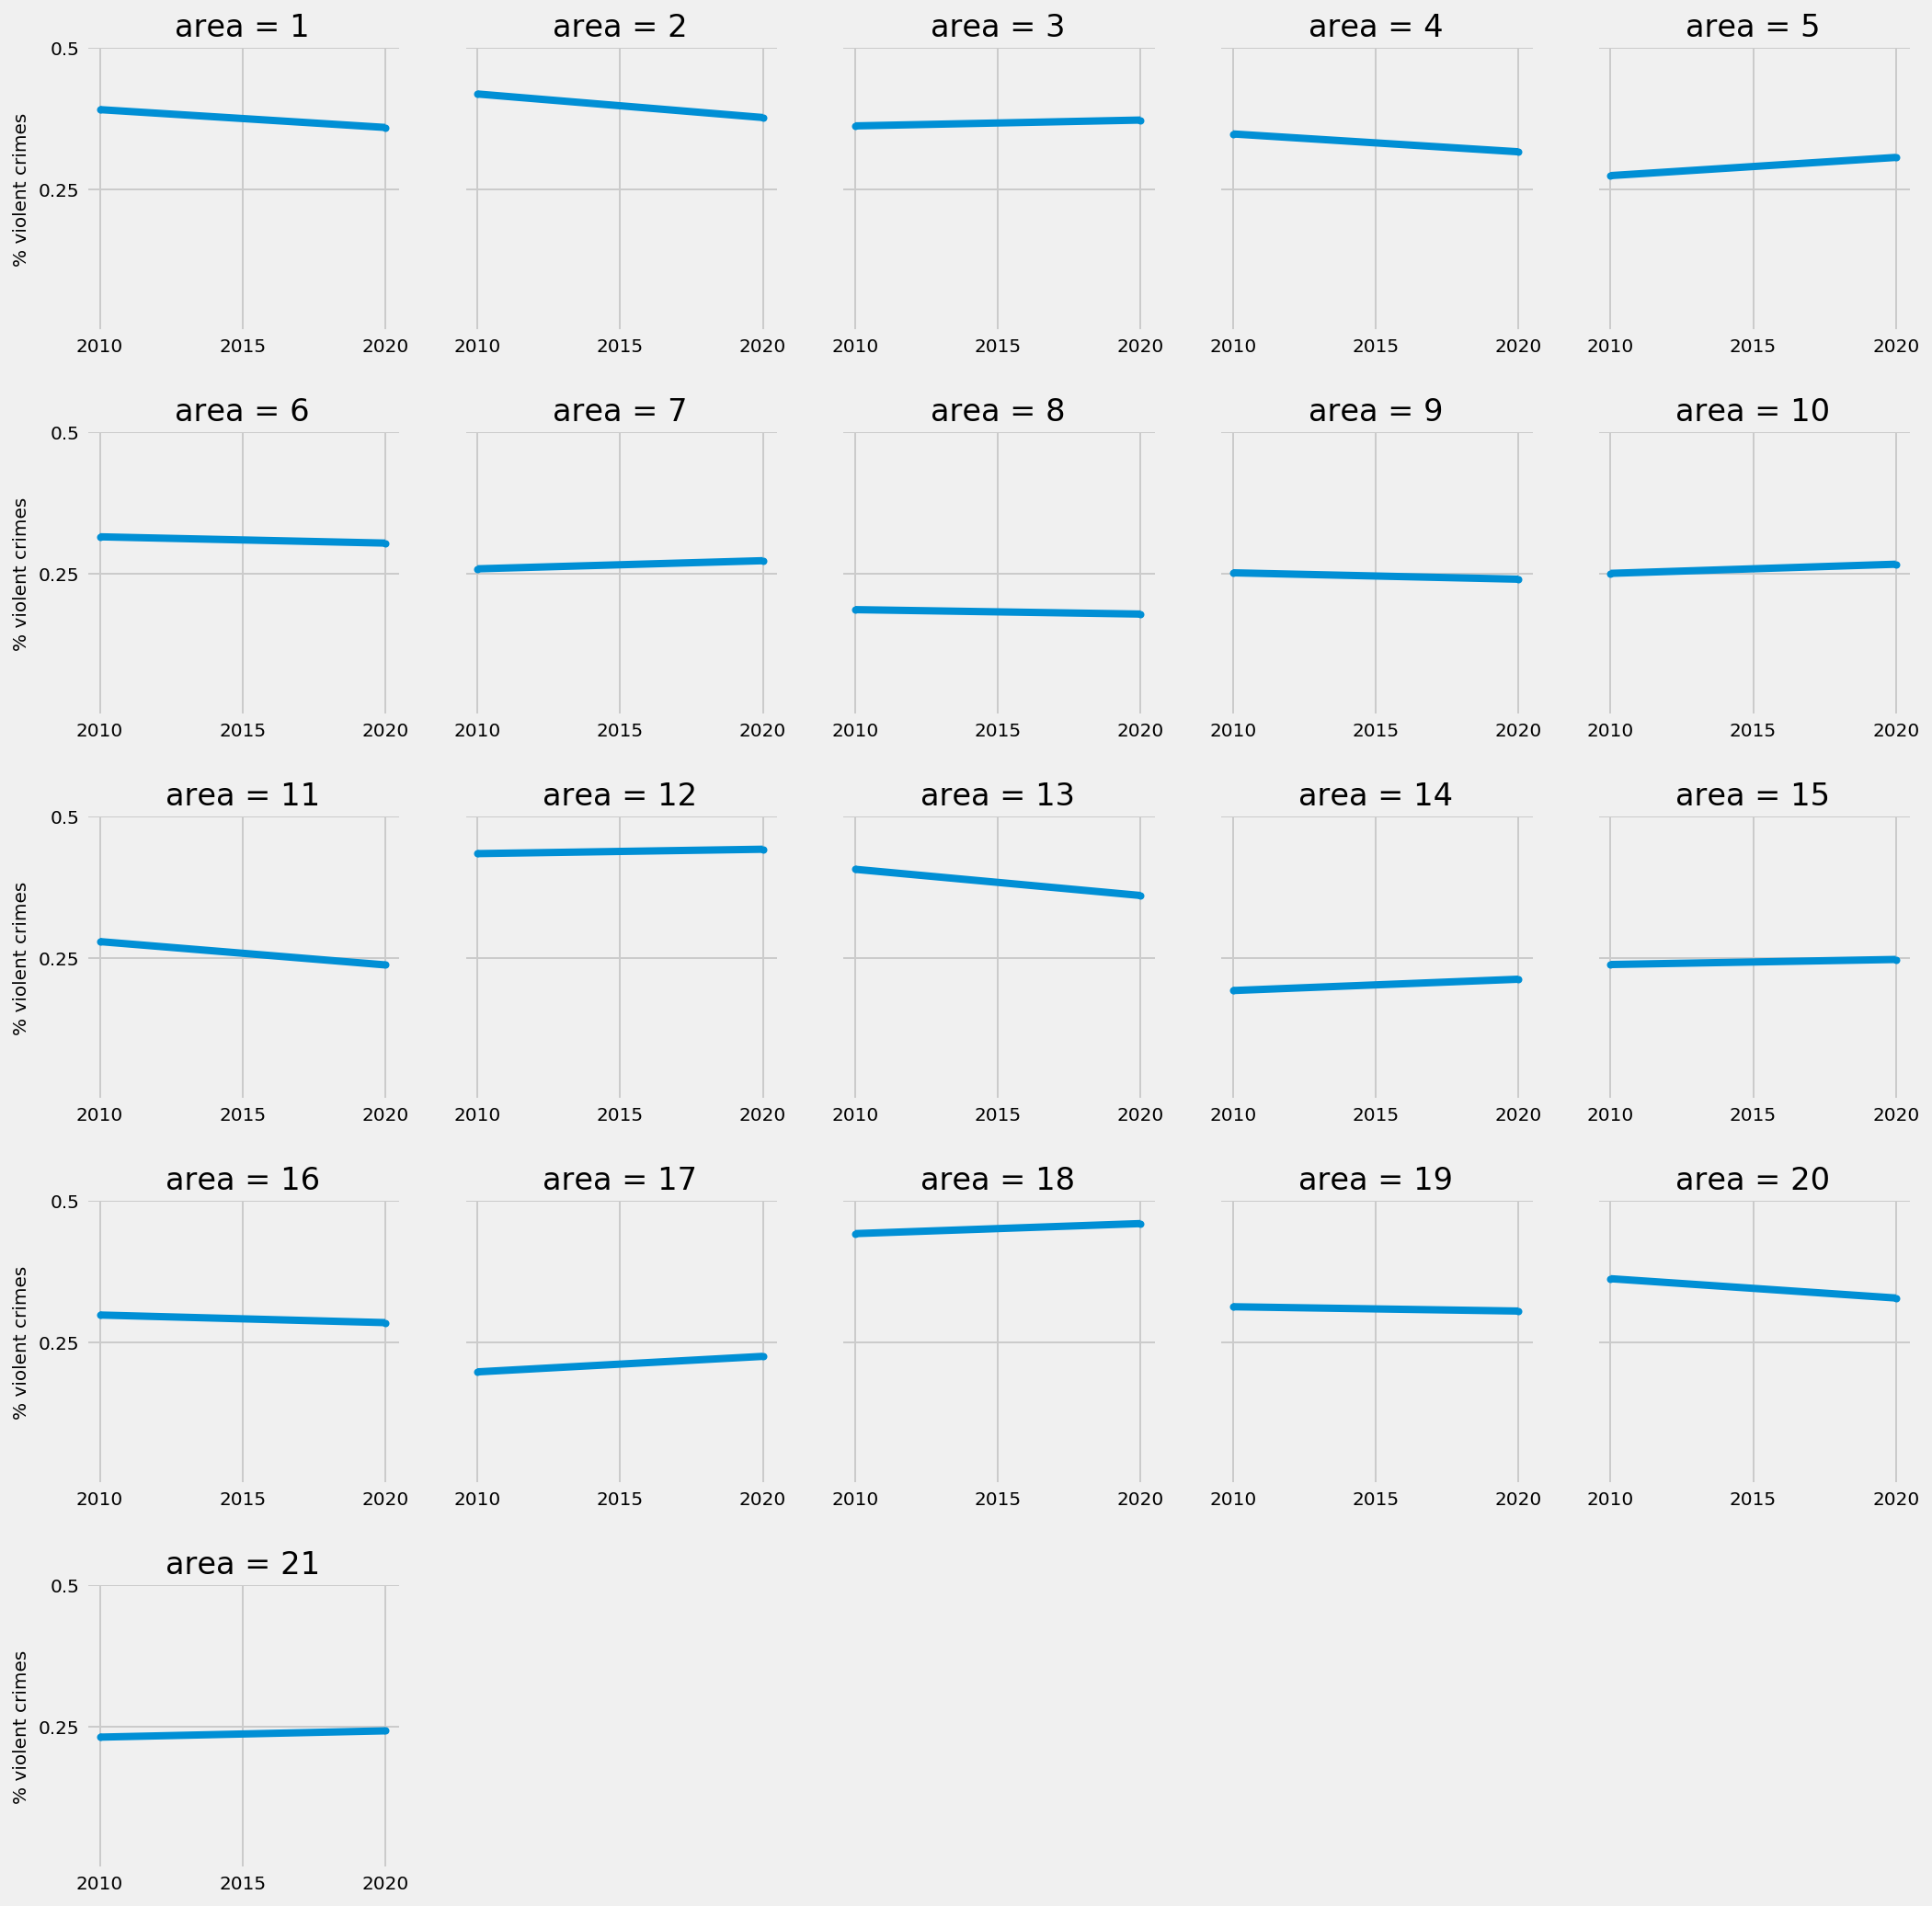

In [175]:
g = sns.FacetGrid(violent_crimes, col="area", col_wrap=5, height=3, sharex=False)
g = (g.map(plt.plot, "year", "percent_violent", marker=".")).set(ylim=(0,.5), yticks=[.25,.5])
#g.set_xlabels([2010,2020], fontsize=10)
g.set_ylabels("% violent crimes", fontsize=10)
g.set_xlabels("")
g.set_yticklabels(labels=[.25,.5], size=10)
g.set_xticklabels(size=10);

plt.savefig('../plots/violent_crimes_area.eps', format='eps', dpi=72)



In [328]:
df[["crm_cd", "vict_age", "area"]].describe()

,crm_cd,vict_age,area
count,2.210104e+06,2.210104e+06,2.210104e+06
mean,5.074893e+02,3.169190e+01,1.107572e+01
std,2.105561e+02,2.069842e+01,6.015147e+00
min,1.100000e+02,-9.000000e+00,1.000000e+00
25%,3.300000e+02,1.900000e+01,6.000000e+00
50%,4.420000e+02,3.200000e+01,1.100000e+01
75%,6.260000e+02,4.600000e+01,1.600000e+01
max,9.560000e+02,1.200000e+02,2.100000e+01


## What's the status of these crimes

In [319]:
df[df["status"]=="IC"].groupby("year")["status"].value_counts()

year  status
2010  IC        166788
2011  IC        157188
2012  IC        150634
2013  IC        144317
2014  IC        144640
2015  IC        160863
2016  IC        171019
2017  IC        176370
2018  IC        176626
2019  IC        171131
2020  IC        84478 
Name: status, dtype: int64

In [317]:
df["status"].value_counts()

IC    1704054
AO    258117 
AA    226255 
JA    16237  
JO    5406   
CC    29     
13    1      
19    1      
TH    1      
Name: status, dtype: int64

In [315]:
df["status_desc"].unique()

array(['Adult Arrest', 'Invest Cont', 'Adult Other', 'Juv Arrest',
       'Juv Other', 'UNK'], dtype=object)